In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('data/features.csv.zip', index_col='match_id')
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [2]:
players = ["{}{}_hero".format(c, i) for c in ['r', 'd'] for i in range(1,6)]
train.filter(players, axis=1).head()

,r1_hero,r2_hero,r3_hero,r4_hero,r5_hero,d1_hero,d2_hero,d3_hero,d4_hero,d5_hero
match_id,,,,,,,,,,
0,11,67,29,20,105,4,42,21,37,84
1,42,49,67,37,26,39,88,79,7,12
2,33,98,20,27,4,22,66,86,29,80
3,29,30,75,37,41,96,48,15,102,20
4,13,27,30,72,93,26,69,22,25,8


In [91]:
def heroesSingle(data):
    wins = {}
    defeats = {}
    for i, match_id in enumerate(data.index):
        for p in range(1,6):
            if data.ix[match_id, 'radiant_win'] == 1:
                wins[data.ix[match_id, 'r{}_hero'.format(p)]] = wins.get(data.ix[match_id, 'r{}_hero'.format(p)], 0) + 1
                defeats[data.ix[match_id, 'd{}_hero'.format(p)]] = defeats.get(data.ix[match_id, 'd{}_hero'.format(p)], 0) + 1
            else:
                wins[data.ix[match_id, 'd{}_hero'.format(p)]] = wins.get(data.ix[match_id, 'd{}_hero'.format(p)], 0) + 1
                defeats[data.ix[match_id, 'r{}_hero'.format(p)]] = defeats.get(data.ix[match_id, 'r{}_hero'.format(p)], 0) + 1
                
    df_wins = pd.DataFrame(list(wins.values()), columns=['wins'], index=wins.keys())
    df_defeats = pd.DataFrame(list(defeats.values()), columns=['defeats'], index=defeats.keys())
    df = df_wins.join(df_defeats)
    df['w-d'] = df['wins'] - df['defeats']
    df['all'] = df['wins'] + df['defeats']
    df['avg_win'] = df['wins'] / df['all']
    return df

In [92]:
heroes = heroesSingle(train)
heroes.head()

,wins,defeats,w-d,all,avg_win
1,5371,5412,-41,10783,0.498099
2,2487,3558,-1071,6045,0.411414
3,5239,5695,-456,10934,0.479148
4,2611,2556,55,5167,0.505322
5,3944,3651,293,7595,0.519289


In [93]:
heroes.sort_values(['w-d'], ascending=False).head(10)

,wins,defeats,w-d,all,avg_win
11,19766,17184,2582,36950,0.534939
85,12335,10056,2279,22391,0.550891
71,14042,11989,2053,26031,0.539434
52,4071,2775,1296,6846,0.594654
28,10345,9190,1155,19535,0.529562
31,5627,4645,982,10272,0.547800
69,4619,3694,925,8313,0.555636
67,4044,3225,819,7269,0.556335
72,17617,16845,772,34462,0.511201
42,5759,4992,767,10751,0.535671


In [94]:
heroes.sort_values(['avg_win'], ascending=False).head(10)

,wins,defeats,w-d,all,avg_win
52,4071,2775,1296,6846,0.594654
102,1834,1460,374,3294,0.556770
67,4044,3225,819,7269,0.556335
69,4619,3694,925,8313,0.555636
85,12335,10056,2279,22391,0.550891
22,4218,3474,744,7692,0.548362
6,2173,1792,381,3965,0.548045
31,5627,4645,982,10272,0.547800
92,1316,1117,199,2433,0.540896
77,635,540,95,1175,0.540426


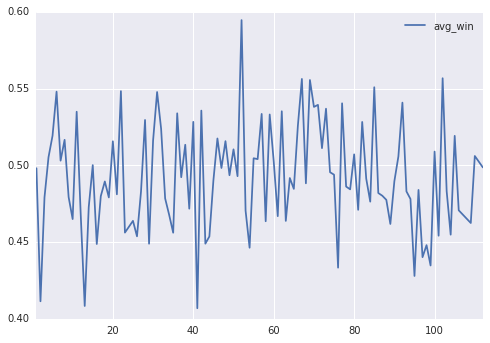

In [111]:
heroes.filter(['avg_win']).plot(y='avg_win')

# Synergy

In [71]:
def heroesPair(data, match_id, p, side):
    heroesPair = (data.ix[match_id, '{}{}_hero'.format(side, p[0])], data.ix[match_id, '{}{}_hero'.format(side, p[1])])
    return tuple(sorted(heroesPair)) # because it's unordered selections

def calculatePairAvgWins(data):
    pairs = [(i,j) for i in range(1,6) for j in range(i+1,6)]
    wins = {}
    defeats = {}
    for i, match_id in enumerate(data.index):
        for p in pairs:
            rp = heroesPair(data, match_id, p, 'r')
            dp = heroesPair(data, match_id, p, 'd')
            if train.ix[match_id, 'radiant_win'] == 1:
                wins[rp] = wins.get(rp, 0) + 1
                defeats[dp] = defeats.get(dp, 0) + 1
            else:
                wins[dp] = wins.get(dp, 0) + 1
                defeats[rp] = defeats.get(rp, 0) + 1
    
    df_wins = pd.DataFrame(list(wins.values()), columns=['wins'], index=wins.keys())
    df_defeats = pd.DataFrame(list(defeats.values()), columns=['defeats'], index=defeats.keys())
    df = df_wins.join(df_defeats)
    df['w-d'] = df['wins'] - df['defeats']
    df['all'] = df['wins'] + df['defeats']
    df['avg_win'] = df['wins'] / df['all']
    return df

In [74]:
pairs = calculatePairAvgWins(train)
pairs.head()

,wins,defeats,w-d,all,avg_win
"(50, 96)",394,419.0,-25.0,813.0,0.484625
"(70, 103)",6,3.0,3.0,9.0,0.666667
"(74, 106)",363,384.0,-21.0,747.0,0.485944
"(39, 70)",320,359.0,-39.0,679.0,0.471281
"(100, 112)",2191,2151.0,40.0,4342.0,0.504606


In [78]:
pairs.shape

(5743, 5)

In [85]:
pairs.sort_values(['avg_win'], ascending=False).head(10)

,wins,defeats,w-d,all,avg_win
"(78, 80)",5,1.0,4.0,6.0,0.833333
"(32, 103)",5,1.0,4.0,6.0,0.833333
"(66, 70)",9,2.0,7.0,11.0,0.818182
"(65, 77)",12,3.0,9.0,15.0,0.800000
"(78, 105)",4,1.0,3.0,5.0,0.800000
"(54, 58)",8,2.0,6.0,10.0,0.800000
"(77, 104)",7,2.0,5.0,9.0,0.777778
"(15, 76)",21,6.0,15.0,27.0,0.777778
"(40, 82)",22,7.0,15.0,29.0,0.758621
"(66, 89)",6,2.0,4.0,8.0,0.750000


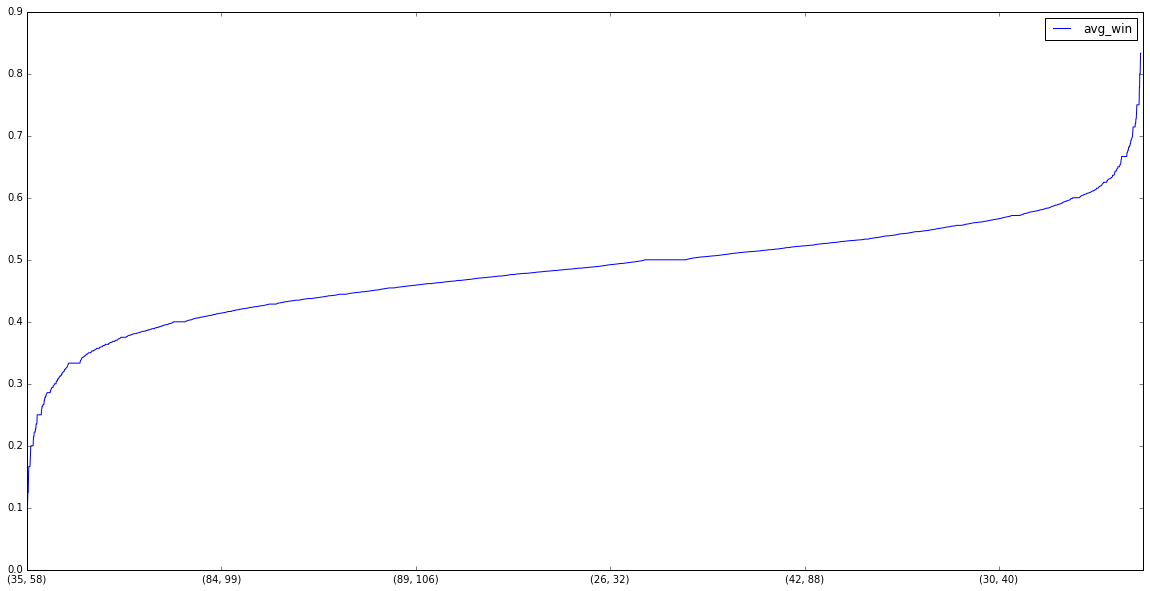

In [88]:
pairs.sort_values(['avg_win']).filter(['avg_win']).plot()